# Proyecto 5: Análisis de sentimiento en reviews de películas

En este proyecto vamos a trabajar con un dataset de reviews de películas. El objectivo es clasificar cada comentario de acuerdo al sentimiento positivo o negativo hacia la película. Para hacerlo, vamos a trabajar con procesamiento de texto para luego aplicar las diferentes técnicas predictivas que hemos visto.

## Dataset

En primer lugar, carguemos las reviews para comenzar a procesarlas. En este caso no tenemos un archivo `.csv`, sino un directorio estructurado de la siguiente forma: 
```
movie_reviews/
  neg/
  pos/
```
`sklearn` nos provee de la función `load_files` que permite recorrer este tipo de estructuras. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'C:/Users/alejandro/Desktop/entrega+5/dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

Ahora en la variable `movies` tendremos guardadas las reviews (`movies.data`) y su sentimiento (`movies.target`).
Veamos cuantas reviews tenemos en total:

In [2]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


Analizando la estructura de los documentos, veamos como luce una muestra de `movies.data`:

In [3]:
movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

Y ahora, con la propiedad `target` podemos ver la categoría asociada a esta review

In [4]:
movie_reviews.target[0]

0

En este caso es un 0, es decir `neg`.

## Separando en conjuntos de entrenamiento y de testeo

Antes de comenzar con el entrenamiento de los modelos probando distintos algoritmos para encontrar los mejores modelos, vamos a separar el conjunto de reviews en training y testing. 

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, stratify=movie_reviews.target, random_state = 12)

## Preprocesamiento

Para trabajar con texto tenemos que realizar una serie de pasos antes de poder entrenar un modelo. Es decir, buscar la forma de convertir el texto a una representación numérica que pueda ser interpretable por los algoritmos de clasificación. 
Para ello vamos a realizar una serie de pasos.
- Tokenizar el texto
- Convertir a vectores de términos/documentos
- Aplicar tfidf


Es importante destacar que el `fit` debe hacerse sobre el conjunto de `train` y no sobre el total, ya que `tfidf` tiene en cuenta la frecuencia de aparición de las palabras respecto al total del conjunto. Una vez que usamos el `fit` con el conjunto de entrenamiento podemos aplicar la transformación al conjunto de `test`. 

**1) Vectorizá** los textos para obtener una matriz de términos/documentos utilizando td-idf. 

In [6]:
# Realizá los pasos necesarios para vectorizar los conjuntos de entrenamiento y testeo en este celda

In [7]:
from nltk.tokenize import word_tokenize
from nltk.text import Text
import nltk
nltk.download('movie_reviews')


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [8]:
X_train

[b"in arguably the most anticipated movie this century , george lucas has achieved a very mixed reaction to a sure blockbuster . \ndespite the fact the script and plot is a bit of a let down , the entire movie on the whole can be considered a milestone in technical excellence , in the sound and special effects department . \nin terms of characters , by far the most outstanding and interesting is queen amidala ( natalie portman ) , whose mature performance far exceeds her tender 14 years of age . \nshe is one ? hot' babe who defines true ? woman leadership' . \nshe not only has a presence , but knows how to take command of the situation and save her planet from ruination . \nno thanks to the jedi knights who although led by the force , lack leadership qualities in terms of thinking up a plan to do anything . \nthe young obi-wan kenobi ( ewan mcgregor ) who has a bad hair day in every scene , gets to kill a bad guy in the end , but lacks a love interest to make him a desirable sort of he

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
Vectorizer = CountVectorizer()
Vectorizer.fit(X_train)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
Vectorizer = TfidfVectorizer()
X_train = Vectorizer.fit_transform(X_train)
X_test = Vectorizer.transform(X_test)





### Dimensión de la matriz de términos
Una vez vectorizados los documentos veamos qué forma tiene la matriz resultante

In [11]:
X_train.shape

(1600, 36342)

__¿ Por qué tiene estas dimensiones ?__

Responder.

Porque el resultado es una matriz de términos por documentos. Por cada término existente en el dataset habrá una columna, ya que no se realizó ningún tipo de filtrado.

## Entrenando los modelos
Una vez que tenemos una matriz con los vectores correspondientes a los documentos luego de aplicarse td-idf podemos comenzar con el proceso de entrenamiento de los modelos. Para eso, vamos a comparar diferentes algoritmos vistos como SVM, Random Forest, AdaBoost, Voting. Y todos los algoritmos complementarios que se quieran introducir. 
Para el entrenamiento de los modelos usaremos GridSearch recorriendo una lista de parámetros según corresponda a cada algoritmo. Además usaremos 5-fold CV y el scoring estará dado por el área bajo la curva roc.

### Support Vector Machines (SVM)

__Ajustar un SVM (kernel lineal) al conjunto de datos de entrenamiento y devolver la matriz de confusión en testing.__

Basándonos en el paper https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, vamos a utilizar un kernel lineal. Al tener menos instancias que features este es el procedimiento recomendado. 

Nuestro espacio de parámetros para recorrer de forma exhaustiva utilizando GridSearch será el siguiente:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 

**2) Entrenar** un modelo utilizando `Grid Search` y el clasificador `LinearSVC` con `5-fold` cross validation y que utilice como `scoring` el área bajo la curva roc.

In [12]:
param_grid = [{'C':[0.001, 0.01, 0.1, 1, 10],'loss':['hinge', 'squared_hinge']}]

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
clf = LinearSVC()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', verbose=True)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10], 'loss': ['hinge', 'squared_hinge']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

Veamos los resultados promediados por cada combinación de parámetros:

In [14]:
means = grid_search.cv_results_['mean_test_score']
print("Top Scores",means)

Top Scores [0.85578906 0.85764063 0.85578906 0.86459375 0.85578906 0.89713281
 0.92157031 0.92445312 0.92204687 0.92314844]


In [15]:
grid_search.best_params_

{'C': 1, 'loss': 'squared_hinge'}

In [16]:
optimised_svm = grid_search.best_estimator_
optimised_svm

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.85

## Matriz de confusión 
Una forma de ver fácilmente el resultado de un clasificador es utilizando una matriz de confusión. A continuación
se presenta una función para visualizar una matriz de confusión utilizando `matplotlib`.

In [18]:
import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



**3) Mostrá** los resultados de la predicción del clasificador `LinearSVC` sobre el conjunto de test con una matriz de confusión

Confusion matrix, without normalization
[[165  35]
 [ 25 175]]


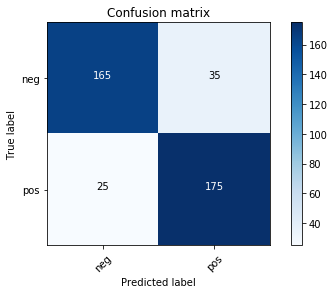

In [19]:
from sklearn.metrics import confusion_matrix
optimised_svm.fit(X_train, y_train)
y_pred = optimised_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred) 
clases = ['neg','pos']
plot_confusion_matrix(conf_matrix, clases)

**4) Calcular** el área bajo la curva ROC (AUC) en el conjunto de testing para el modelo y mostrá el `classification_report`

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
print ('Roc Auc Score : ',roc_auc_score(y_test, y_pred) )
print ('Reporte : ', classification_report(y_test, y_pred, target_names=['neg', 'pos']))


Roc Auc Score :  0.85
Reporte :                precision    recall  f1-score   support

         neg       0.87      0.82      0.85       200
         pos       0.83      0.88      0.85       200

   micro avg       0.85      0.85      0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



### Random Forests
El siguiente modelo que vamos a entrenar es utilizando la técnica de Random Forest. 

__5) Usando grid search__ con cross validation (5 folds), encontrar el mejor modelo según el AUC dado el siguiente espacio de búsqueda:

* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]

(puede tardar un poco la ejecución dado el tamaño del dataset)

In [21]:
param_grid = [{'n_estimators':[100, 500, 1000],'max_depth':[3, 7, None], 'min_samples_leaf':[2, 3, 10], 'bootstrap':[True,False], 'criterion':["gini","entropy"]},]

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
RFC_clf = RandomForestClassifier()
grid_search = GridSearchCV(RFC_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=1, return_train_score=True)

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Random Forest`. Es decir, mostrar la matriz de confusión, scores, etc

Confusion matrix, without normalization
[[170  30]
 [ 40 160]]


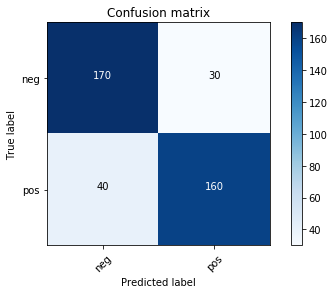

In [23]:
from sklearn.metrics import confusion_matrix
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred) 
clases = ['neg','pos']
plot_confusion_matrix(conf_matrix, clases)

In [25]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score

print ('Roc Auc Score :',roc_auc_score(y_test, y_pred) )
print ('Calssification Report : ', classification_report(y_test, y_pred) )

print('Best Score:', grid_search.best_score_)
print('Best Params:', grid_search.best_params_ )

Roc Auc Score : 0.825
Calssification Report :                precision    recall  f1-score   support

           0       0.81      0.85      0.83       200
           1       0.84      0.80      0.82       200

   micro avg       0.82      0.82      0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

Best Score: 0.9013984374999999
Best Params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 1000}


### Multilayer Perceptron

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Multilayer Perceptron`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'hidden_layer_sizes': [(10,),(5,5), (2,2)]}`

In [26]:
param_grid = [{'hidden_layer_sizes':[(10,),(5,5),(2,2)]}]

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
MLPC = MLPClassifier()
grid_search = GridSearchCV(MLPC, param_grid, cv=5, scoring='roc_auc', verbose=1, return_train_score=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.4min finished


Confusion matrix, without normalization
[[165  35]
 [ 23 177]]


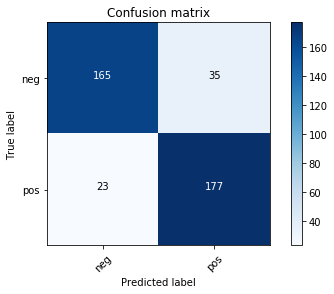

In [21]:
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

from sklearn.metrics import confusion_matrix 

conf_matrix = confusion_matrix(y_test, y_pred) 
clases = ['neg','pos']

plot_confusion_matrix(conf_matrix, clases)

In [28]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score

print ('Roc Auc Score :',roc_auc_score(y_test, y_pred) )
print ('Calssification Report : ', classification_report(y_test, y_pred) )

Roc Auc Score : 0.825
Calssification Report :                precision    recall  f1-score   support

           0       0.81      0.85      0.83       200
           1       0.84      0.80      0.82       200

   micro avg       0.82      0.82      0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



### AdaBoost

**7) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `AdaBoost`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'n_estimators': [50, 100, 500]}`


In [29]:
param_grid = {'n_estimators':[50, 100, 500]}

In [30]:
from sklearn.ensemble import AdaBoostClassifier
AdaB = AdaBoostClassifier()
grid_search = GridSearchCV(AdaB, param_grid, cv=5, scoring='roc_auc', verbose=1, return_train_score=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.1min finished


Confusion matrix, without normalization
[[163  37]
 [ 43 157]]


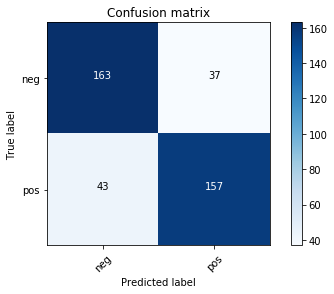

In [31]:
grid_search.fit(X_train, y_train)
y_pred_ada = grid_search.predict(X_test)

from sklearn.metrics import confusion_matrix 

conf_matrix = confusion_matrix(y_test, y_pred_ada) 
clases = ['neg','pos']

plot_confusion_matrix(conf_matrix, clases)

In [32]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score

print ('Roc Auc Score :',roc_auc_score(y_test, y_pred_ada) )
print ('Calssification Report : ', classification_report(y_test, y_pred_ada) )

Roc Auc Score : 0.7999999999999999
Calssification Report :                precision    recall  f1-score   support

           0       0.79      0.81      0.80       200
           1       0.81      0.79      0.80       200

   micro avg       0.80      0.80      0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



__8) Armar un ensamble entre los cuatro modelos usando votación y medir el accuracy de cada uno de los modelos.__


Confusion matrix, without normalization
[[163  43]
 [ 37 157]]


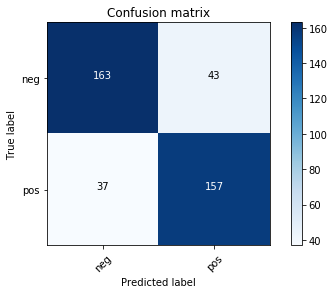

Area bajo la curva ROC: 0.8458447767266809
Classification Report:

                precision    recall  f1-score   support

         neg       0.80      0.91      0.85       200
         pos       0.89      0.78      0.83       200

   micro avg       0.84      0.84      0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400



In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

RFC_clf = RandomForestClassifier()
clf = LinearSVC()      
MLPC = MLPClassifier()    
AdaB = AdaBoostClassifier()
voting_clf= VotingClassifier(estimators = [('Linear', clf), ('Random', RFC_clf), ('Multi', MLPC), ('ADA', AdaB)], voting='hard')
    
voting_clf.fit(X_train, y_train)
y_pred_vcfl = voting_clf.predict(X_test)      
               
classes = ['neg', 'pos'] 
cm_voting_clf= confusion_matrix(y_pred_ada, y_test)
plot_confusion_matrix(cm_voting_clf, classes)


auc_score_voting_clf= roc_auc_score(y_pred_vcfl, y_test)
print('Area bajo la curva ROC: {}'. format(auc_score_voting_clf))
print('Classification Report:\n\n ', classification_report(y_test, y_pred_vcfl, target_names=['neg', 'pos']))

In [41]:
from sklearn.metrics import accuracy_score

classifiers = [clf, RFC_clf, MLPC, AdaB, voting_clf ]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LinearSVC 0.85
RandomForestClassifier 0.6475
MLPClassifier 0.8575
AdaBoostClassifier 0.75
VotingClassifier 0.8


__9) Seleccioná el modelo__ que te haya dado el mejor score y utilizalo como tu modelo final. Reentrenalo con todos tus datos de entrenamiento.


In [42]:
from sklearn.externals import joblib
joblib.dump(voting_clf, 'sentiment.pkl')
voting_clf = joblib.load('sentiment.pkl ')

In [43]:
voting_clf.fit(X_train, y_train)

y_pred= voting_clf.predict(X_test)

## Clasificación de reviews de Rocky 4.

A partir de [criticas de la película Rocky 4](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user) veamos como las clasifica nuestro mejor modelo

In [48]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = Vectorizer.transform(reviews_new)
reviews_new_tfidf = Vectorizer.transform(reviews_new)

In [50]:
pred = clf.predict(reviews_new_tfidf)

In [51]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => pos 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => neg 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth